# Importing the necessary modules

In [1]:
import numpy as np
from scipy.fftpack import dct, idct
import cv2
from collections import Counter
import heapq
import json
import os
import pickle

# Computation of DCT Coefficients

In [2]:
# Function to perform Discrete Cosine Transform (DCT) on an 8x8 block
def dct_2d(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Quantization

In [3]:
# Function to quantize a DCT block
def quantize(block, Q, A):
    M = (50/Q) * A
    BLOCK =  (np.round(block / M)).astype(int)
    return BLOCK

# Huffman encoding and Run length encoding

In [4]:
# Function to divide the image into 8x8 blocks
def divide_into_blocks(image):
    h, w = image.shape
    h_blocks = h // 8
    w_blocks = w // 8
    blocks = []
    for i in range(h_blocks):
        for j in range(w_blocks):
            block = image[i*8:(i+1)*8, j*8:(j+1)*8]
            blocks.append(block)
    return blocks

# Perform a zigzag scan on an 8x8 block to order coefficients.
def zigzag_scan(block):
    zigzag_order = [
        (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
        (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
        (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
        (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
        (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
        (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
        (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
        (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)
    ]
    return [block[i, j] for i, j in zigzag_order]

# Collect all AC coefficients (non-zero and zero) from quantized blocks.
def collect_ac_coefficients(quantized_blocks):
    coefficients = []
    for block in quantized_blocks:
        zigzag_coefficients = zigzag_scan(block)
        coefficients.extend(zigzag_coefficients[1:])  # Skip the DC coefficient
    return coefficients

# Collect all DC coefficients from quantized blocks.
def collect_dc_coefficients(quantized_blocks):
    return [int(block[0, 0]) for block in quantized_blocks]

# Generate Huffman encoding for the given data.
def huffman_encoding(data):
    # Calculate frequency of each value
    data_non_zero = [x for x in data if x != 0]
    frequency = Counter(data_non_zero)
    heap = [[int(weight), [int(symbol), ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)

    # Build the Huffman Tree
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Create Huffman dictionary with `int` keys and str values
    huffman_dict = {int(k): str(v) for k, v in dict(heapq.heappop(heap)[1:]).items()}
    return huffman_dict

# Encode AC coefficients using run-length and Huffman encoding.
def encode_ac_coefficients(ac_coefficients, ac_huffman_table):
    encoded_ac = []
    run_length = 0
    for coefficient in ac_coefficients:
        coefficient = int(coefficient)  # Ensure Python int
        if coefficient == 0:
            run_length += 1
        else:
            huffman_code = ac_huffman_table[coefficient]  # Python int lookup
            size = len(huffman_code)
            encoded_ac.append((int(run_length), size, str(huffman_code)))
            run_length = 0

    # Ensure we append EOB (End of Block) symbol if necessary
    if run_length > 0:
        encoded_ac.append((0, 0, '0'))  # EOB symbol

    return encoded_ac

# Generate Huffman encoding for dc values.
def huffman_encoding_dc1(data):
    # Calculate frequency of each value
    frequency = Counter(data)
    heap = [[weight, [int(symbol), ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)

    # Build the Huffman Tree
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Create Huffman dictionary with `int` keys and str values
    huffman_dict = {int(k): str(v) for k, v in dict(heapq.heappop(heap)[1:]).items()}
    return huffman_dict

# Encode DC coefficients difference using Huffman encoding.
def huffman_encoding_dc(dc_coefficients):
    dc_coeff_encoded_data = [int(dc_coefficients[0])]  # First DC coefficient is explicitly stored
    for i in range(1, len(dc_coefficients)):
        diff = int(dc_coefficients[i]) - int(dc_coefficients[i-1])
        dc_coeff_encoded_data.append(diff)

    # Create the Huffman table for the differences
    dc_huffman_table = huffman_encoding_dc1(dc_coeff_encoded_data[1:])  # Skip the first coefficient in the diff
    return dc_huffman_table

# JPEG Encoder

In [5]:
def jpeg_encoder(image, Q, A):
    # Convert image to grayscale if not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    original_shape = image.shape[:2]  # Height and width
    height, width = original_shape
    # Calculate new dimensions (multiples of 8)
    new_height = (height // 8) * 8
    new_width = (width // 8) * 8

    # Crop the image
    image = image[:new_height, :new_width]

    # Subtract 128 from each pixel
    image = image.astype(np.float32) - 128

    # Divide image into 8x8 blocks
    blocks = divide_into_blocks(image)

    # Perform DCT on each block
    dct_blocks = [dct_2d(block) for block in blocks]

    # Quantize each block
    quantized_blocks = [quantize(block, Q, A) for block in dct_blocks]
    #print(quantized_blocks[700])

    # Collect DC and AC coefficients
    dc_coefficients = collect_dc_coefficients(quantized_blocks)
    ac_coefficients = collect_ac_coefficients(quantized_blocks)

    # Perform separate Huffman encoding for DC and AC coefficients
    dc_huffman_table = huffman_encoding_dc(dc_coefficients)
    ac_huffman_table = huffman_encoding(ac_coefficients)

    # Encode each block using separate Huffman codes
    encoded_blocks = []
    prev_dc = 0

    for i, block in enumerate(quantized_blocks):
        # Zigzag order
        zigzag_coefficients = zigzag_scan(block)

        # DC coefficient encoding
        if i == 0:
            # First block: Store DC coefficient explicitly
            dc_encoded = int(zigzag_coefficients[0])
        else:
            # Compute difference and Huffman encode it
            diff = zigzag_coefficients[0] - prev_dc
            dc_encoded = str(dc_huffman_table[diff])

        # Update the previous DC coefficient
        prev_dc = zigzag_coefficients[0]

        # AC coefficient encoding
        ac_coefficients = zigzag_coefficients[1:]
        ac_encoded = encode_ac_coefficients(ac_coefficients, ac_huffman_table)

        # Store the DC and AC encodings
        encoded_blocks.append([dc_encoded, ac_encoded])

    return encoded_blocks, dc_huffman_table, ac_huffman_table

# Saving the JPEG Encoded File

In [6]:
# Save the JPEG-encoded data to a binary file
def save_jpeg_encoded_file(encoded_blocks, dc_huffman_table, ac_huffman_table, Quality_factor, image_shape, color_mode, output_file):
    # Prepare the data
    jpeg_data = {
        "image_shape": image_shape,
        "color_mode": color_mode,
        "quality_factor": Quality_factor,
        "dc_huffman_table": dc_huffman_table,
        "ac_huffman_table": ac_huffman_table,
        "encoded_blocks": encoded_blocks
    }
    
    # Serialize and save
    with open(output_file, "wb") as f:
        pickle.dump(jpeg_data, f, protocol=pickle.HIGHEST_PROTOCOL)

# Reading the JPEG Encoded File

In [7]:
# Read the JPEG-encoded data from a binary file
def read_jpeg_encoded_file(input_file):
    with open(input_file, "rb") as f:
        jpeg_data = pickle.load(f)
    return (jpeg_data["image_shape"], jpeg_data["quality_factor"],jpeg_data["dc_huffman_table"], jpeg_data["ac_huffman_table"],jpeg_data["encoded_blocks"])

encoded_blocks[2i] and encoded_blocks[2i+1] correspond to the DC and AC coefficients of the (i+1)th block

# Decoding the AC and DC Coefficients

In [8]:
def decode_dc_coefficients(encoded_dc, dc_huffman_table): # Decode the DC coefficients from the encoded data using the Huffman table.
    # Reverse the DC Huffman table for decoding
    reverse_dc_huffman_table = {v: k for k, v in dc_huffman_table.items()}

    # Decode DC differences
    dc_differences = [encoded_dc[0]]  # The first DC coefficient is explicitly stored
    for code in encoded_dc[1:]:
        diff = int(reverse_dc_huffman_table[code])
        dc_differences.append(diff)

    # Reconstruct absolute DC coefficients
    dc_coefficients = [dc_differences[0]]
    for i in range(1, len(dc_differences)):
        dc_coefficients.append(dc_coefficients[i-1] + dc_differences[i])

    return dc_coefficients

def decode_ac_coefficients(encoded_ac, ac_huffman_table): # Decode the AC coefficients from the encoded data using the Huffman table.
    # Reverse the AC Huffman table for decoding
    reverse_ac_huffman_table = {v: k for k, v in ac_huffman_table.items()}

    # Initialize the AC coefficients array
    ac_coefficients = []

    for run_length, size, huffman_code in encoded_ac:
        if run_length == 0 and size == 0:
            # End of Block (EOB)
            break

        # Decode the coefficient value
        coefficient = reverse_ac_huffman_table[huffman_code]

        # Add zeros for the run length
        ac_coefficients.extend([0] * run_length)

        # Add the actual coefficient
        ac_coefficients.append(coefficient)

    # Pad with zeros to make 63 coefficients
    while len(ac_coefficients) < 63:
        ac_coefficients.append(0)

    return ac_coefficients

def decode_blocks(encoded_blocks, dc_huffman_table, ac_huffman_table): # Decode all blocks from the encoded data
    decoded_blocks = []

    # Decode DC coefficients for all blocks
    dc_encoded = [encoded_blocks[0][0]]
    for i in range(1,len(encoded_blocks)):
        dc_encoded.append(encoded_blocks[i][0])
    dc_coefficients = decode_dc_coefficients(dc_encoded, dc_huffman_table)

    # Decode AC coefficients for each block
    for i in range(len(dc_coefficients)):
        # Get the DC coefficient for this block
        dc_coefficient = dc_coefficients[i]
        ac_encoded = encoded_blocks[i][1]
        # Decode the AC coefficients
        ac_coefficients = decode_ac_coefficients(ac_encoded, ac_huffman_table)

        # Combine DC and AC coefficients
        zigzag_coefficients = [dc_coefficient] + ac_coefficients

        # Reconstruct the 8x8 block from zigzag order
        block = np.zeros((8, 8), dtype=int)
        zigzag_order = [
            (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
            (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
            (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
            (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
            (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
            (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
            (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
            (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)
        ]
        for (i, j), coefficient in zip(zigzag_order, zigzag_coefficients):
            block[i, j] = coefficient

        decoded_blocks.append(block)

    return decoded_blocks

# Dequantization

In [9]:
# Function to dequantize a block
def dequantize(block, Q, A):
    M = (50 / Q) * A
    return block * M

# Reconstructing the image patches by taking Inverse DCT

In [10]:
# Function to perform Inverse Discrete Cosine Transform (IDCT) on an 8x8 block
def idct_2d(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Function to reconstruct image patches from decoded blocks
def reconstruct_patches(decoded_blocks, Q, A):
    image_patches = []
    for block in decoded_blocks:
        # Dequantize the block
        dequantized_block = dequantize(block, Q, A)
        
        # Perform inverse DCT
        spatial_block = idct_2d(dequantized_block)
        
        # Add 128 to restore original pixel values
        restored_block = np.round(spatial_block + 128).astype(np.uint8)

        restored_block = np.clip(restored_block, 0, 255)
        
        # Append the restored 8x8 patch
        image_patches.append(restored_block)
    
    return image_patches

# Combining the image patches to get the final image

In [11]:
def combine_patches(image_patches, image_shape):
    h, w = image_shape
    h_blocks = h // 8
    w_blocks = w // 8

    # Initialize an empty array for the reconstructed image
    reconstructed_image = np.zeros((h_blocks*8, w_blocks*8), dtype=np.uint8)

    # Place each patch into its correct position
    for i in range(h_blocks):
        for j in range(w_blocks):
            patch_idx = i * w_blocks + j
            reconstructed_image[i*8:(i+1)*8, j*8:(j+1)*8] = image_patches[patch_idx]
    
    return reconstructed_image

# Saving the obtained compressed image

In [12]:
def save_image_and_check_size(image, output_file, input_file):
    # Save the image
    cv2.imwrite(output_file, image)

    # Check file size in bytes and convert to KB
    file_size_bytes = os.path.getsize(output_file)
    file_size_kb = file_size_bytes / 1024.0
    input_file_size_bytes = os.path.getsize(input_file)
    input_file_size_kb = input_file_size_bytes / 1024.0

    # print(f"Image saved as: {output_file}")
    # print(f"Input File size: {input_file_size_kb:.2f} KB")
    # print(f"File size: {file_size_kb:.2f} KB")

# Grayscale JPEG Compressor

In [13]:
def grayscale_jpeg_compressor(input_image, Quality_factor):

    # Quantization matrix for Q = 50
    A = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]]).astype(int)

    # Compress the image with updated DC encoding logic
    encoded_blocks, dc_huffman_table, ac_huffman_table = jpeg_encoder(input_image, Quality_factor, A)

    # Print Huffman tables and encoded data for the first block
    #print("DC Huffman Table:", dc_huffman_table)
    #print("AC Huffman Table:", ac_huffman_table)
    #print("Encoded DC and AC for the first block:", encoded_blocks[8])
    
    # Save the JPEG-encoded file
    save_jpeg_encoded_file(
        encoded_blocks=encoded_blocks,
        dc_huffman_table=dc_huffman_table,
        ac_huffman_table=ac_huffman_table,
        Quality_factor=Quality_factor,  # Quantization matrix
        image_shape=input_image.shape,
        color_mode="grayscale",  # Change to "color" for color images
        output_file="Color_compressed_image.bin"
    )
    input_file = "Color_compressed_image.bin"
    image_shape_2, quality_factor_2, dc_huffman_table_2, ac_huffman_table_2, encoded_blocks_2 = read_jpeg_encoded_file(input_file)

    # Print the extracted information
    # print("Image Shape:", image_shape)
    # print("Quality Factor:", quality_factor)
    #print("DC Huffman Table:", dc_huffman_table)
    #print("AC Huffman Table:", ac_huffman_table)
    #print("Encoded Blocks:", encoded_blocks[:5])  # Print the first 5 blocks as an example

    decoded_blocks = decode_blocks(encoded_blocks_2, dc_huffman_table_2, ac_huffman_table_2)

    # Print the first decoded block
    # print("Decoded Block 1:\n", decoded_blocks[700])

    # Example: Reconstruct patches with Q = 50
    image_patches = reconstruct_patches(decoded_blocks, quality_factor_2, A)

    # Display the first patch
    # print("Image Patch 1:\n", image_patches[0])

    # Combine patches into the final image
    final_image = combine_patches(image_patches, image_shape_2)

    # Display or save the image
    #cv2.imshow("Compressed Image", final_image)
    #cv2.imshow("Input Image", input_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Save the reconstructed image and check its size
    return final_image

# Color JPEG Compressor

In [14]:
def color_jpeg_compressor(image_address, Quality_factor):
    # Load the color image
    image = cv2.imread(image_address)  # BGR format in OpenCV

    original_shape = image.shape[:2]  # Height and width
    height, width = original_shape
    # Calculate new dimensions (multiples of 8)
    new_height = (height // 8) * 8
    new_width = (width // 8) * 8

    # Crop the image
    image = image[:new_height, :new_width]
    
    # Convert the image to YCbCr color space
    ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    y = ycbcr_image[:, :, 0]
    cb = ycbcr_image[:, :, 1]
    cr = ycbcr_image[:, :, 2]

    # Downsample chrominance channels
    cb_downsampled = cv2.resize(cb, (cb.shape[1] // 2, cb.shape[0] // 2), interpolation=cv2.INTER_AREA)
    cr_downsampled = cv2.resize(cr, (cr.shape[1] // 2, cr.shape[1] // 2), interpolation=cv2.INTER_AREA)

    # Apply JPEG Compression on each channel
    processed_y = grayscale_jpeg_compressor(y, Quality_factor)
    processed_cb = grayscale_jpeg_compressor(cb_downsampled, Quality_factor)
    processed_cr = grayscale_jpeg_compressor(cr_downsampled, Quality_factor)

    # Upsample chrominance channels
    cb_upsampled = cv2.resize(processed_cb, (cb.shape[1], cb.shape[0]), interpolation=cv2.INTER_AREA)
    cr_upsampled = cv2.resize(processed_cr, (cr.shape[1], cr.shape[0]), interpolation=cv2.INTER_AREA)

    # Merge the channels back into YCbCr
    ycbcr_compressed = cv2.merge((processed_y, cb_upsampled, cr_upsampled))

    # Convert YCbCr to BGR (or RGB)
    compressed_image = cv2.cvtColor(ycbcr_compressed, cv2.COLOR_YCrCb2BGR)

    # Save the compressed image
    cv2.imwrite('Color_Compressed_image.jpg', compressed_image)

# Example Usage

In [15]:
Quality_factor = 8
image_address = '../images/ajit.jpg'
color_jpeg_compressor(image_address,Quality_factor)

# Graphs

Processing ../images/Kodak\kodim01.png...
Processing ../images/Kodak\kodim02.png...
Processing ../images/Kodak\kodim03.png...
Processing ../images/Kodak\kodim04.png...
Processing ../images/Kodak\kodim05.png...
Processing ../images/Kodak\kodim06.png...
Processing ../images/Kodak\kodim07.png...
Processing ../images/Kodak\kodim08.png...
Processing ../images/Kodak\kodim09.png...
Processing ../images/Kodak\kodim10.png...
Processing ../images/Kodak\kodim11.png...
Processing ../images/Kodak\kodim12.png...
Processing ../images/Kodak\kodim13.png...
Processing ../images/Kodak\kodim14.png...
Processing ../images/Kodak\kodim15.png...
Processing ../images/Kodak\kodim16.png...
Processing ../images/Kodak\kodim17.png...
Processing ../images/Kodak\kodim18.png...
Processing ../images/Kodak\kodim19.png...
Processing ../images/Kodak\kodim20.png...
Processing ../images/Kodak\kodim21.png...
Processing ../images/Kodak\kodim22.png...
Processing ../images/Kodak\kodim23.png...
Processing ../images/Kodak\kodim24

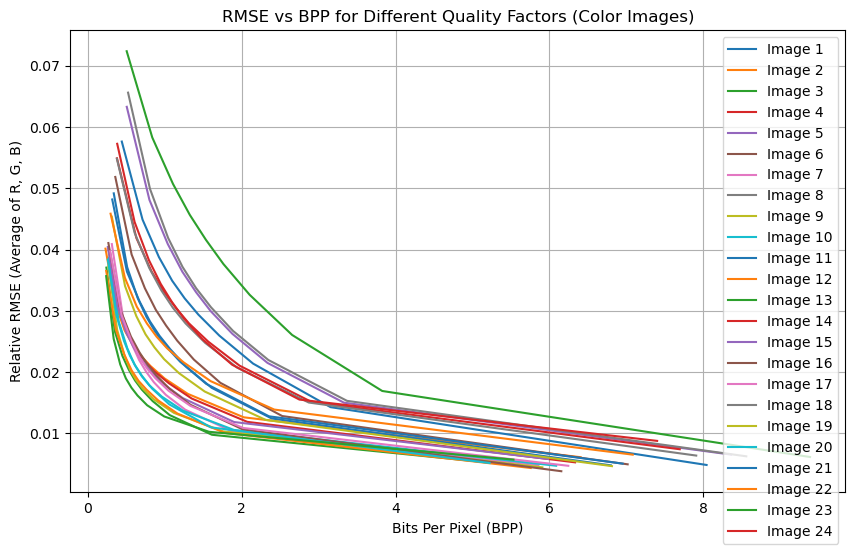

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- RMSE Calculation ---
def calculate_rmse(original, compressed):
    """Calculate the RMSE between the original and compressed images."""
    # Ensure the images are the same size
    h = original.shape[0] // 8 * 8
    w = original.shape[1] // 8 * 8
    original = original[:h, :w]
    compressed = compressed[:h, :w]

    # Calculate RMSE for each channel
    diff = original.astype(np.float32) - compressed.astype(np.float32)
    mse = np.mean(diff**2, axis=(0, 1))  # Per-channel mean squared error
    rmse = np.sqrt(mse)
    
    # Normalize RMSE for 8-bit images
    return rmse / 255.0  # Returns RMSE for each channel as an array

# --- BPP Calculation ---
def calculate_bpp(compressed_file, image_shape):
    """Calculate the Bits Per Pixel (BPP)."""
    file_size_bits = os.path.getsize(compressed_file) * 8  # Convert bytes to bits
    num_pixels = image_shape[0] * image_shape[1]
    return file_size_bits / num_pixels

# --- Image Compression and Decompression ---
def process_image(image_address, quality_factors):
    """Compress and decompress an image for various Quality Factors, calculating RMSE and BPP for each."""
    input_image = cv2.imread(image_address, cv2.IMREAD_COLOR)  # Load as color
    rmse_values = []
    bpp_values = []

    for Q in quality_factors:
        color_jpeg_compressor(image_address,Q)
        compressed_file = "./Color_Compressed_image.jpg"
        # Save the compressed image with the current quality factor
        cv2.imwrite(compressed_file, input_image, [cv2.IMWRITE_JPEG_QUALITY, Q])

        # Load the compressed image
        compressed_image = cv2.imread(compressed_file, cv2.IMREAD_COLOR)

        # Calculate metrics
        rmse = calculate_rmse(input_image, compressed_image)
        bpp = calculate_bpp(compressed_file, input_image.shape)

        # Use the mean RMSE across channels for summary
        rmse_values.append(np.mean(rmse))  # Average RMSE across R, G, B
        bpp_values.append(bpp)

    return rmse_values, bpp_values

# --- Main Function for Multiple Images ---
def main(image_folder):
    """Process multiple images, calculate RMSE and BPP for various Quality Factors, and plot the results."""
    # Parameters
    quality_factors = list(range(10, 101, 10))  # Quality Factors from 10 to 100
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.JPEG') or f.endswith('.png')]

    all_rmse = []
    all_bpp = []

    for img_file in image_files:  # Process up to 20 images
        print(f"Processing {img_file}...")
        rmse_values, bpp_values = process_image(img_file, quality_factors)
        all_rmse.append(rmse_values)
        all_bpp.append(bpp_values)

    # Plot results
    plt.figure(figsize=(10, 6))
    for i in range(len(all_rmse)):
        plt.plot(all_bpp[i], all_rmse[i], label=f"Image {i+1}")
    plt.xlabel("Bits Per Pixel (BPP)")
    plt.ylabel("Relative RMSE (Average of R, G, B)")
    plt.title("RMSE vs BPP for Different Quality Factors (Color Images)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return all_rmse, all_bpp

# --- Run Experiment ---
image_folder = "../images/Kodak"  # Path to folder containing images
all_rmse, all_bpp = main(image_folder)